# MPC 

## Involve solving quadratic programs for the future time 

$
\renewcommand{\jmatc}[4]{\left[ \ba{cc} #1 & #2 \\[.5em] #3 & #4 \ea \right]}
\newcommand{\jmatr}[4]{\left[ \ba{rr} #1 & #2 \\[.5em] #3 & #4 \ea \right]}
\newcommand{\jmthr}[9]{\left[ \ba{rrr} #1 & #2 & #3 \\ #4 & #5 & #6 \\ #7 & #8 & #9\ea \right]}
\newcommand{\jvthr}[3]{\left[ \ba{r} #1 \\ #2 \\ #3\ea \right]}
\newcommand{\jhthr}[3]{\left[ \ba{rrr} #1 & #2 & #3\ea \right]}
\newcommand{\jvechc}[2]{\left[ \ba{cc} #1 & #2 \ea \right]}
\newcommand{\jcolc}[2]{\left[ \ba{c} #1 \\ #2 \ea \right]}
\newcommand{\jvecvc}[2]{\left[ \ba{c} #1 \\ #2 \ea \right]}
\newcommand{\bmat}{\begin{bmatrix}}
\newcommand{\emat}{\end{bmatrix}}
\newcommand{\expect}[1]{\expec\left[ #1 \right]}
\newcommand{\mb}{\mathbf}
\newcommand{\argmax}{\operatornamewithlimits{argmax}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\bea}{\begin{eqnarray}}
\newcommand{\eea}{\end{eqnarray}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\ba}{\begin{array}}
\newcommand{\ea}{\end{array}}
\newcommand{\njbu}{\mathbf{u}}
\newcommand{\njbf}{\mathbf{f}}
\newcommand{\njbg}{\mathbf{g}}
\newcommand{\njbh}{\mathbf{h}}
\newcommand{\njba}{\mathbf{a}}
\newcommand{\njbb}{\mathbf{b}}
\newcommand{\njbi}{\mathbf{i}}
\newcommand{\njbe}{\mathbf{e}}
\newcommand{\njbd}{\mathbf{d}}
\newcommand{\njbp}{\mathbf{p}}
\newcommand{\njbq}{\mathbf{q}}
\newcommand{\njbr}{\mathbf{r}}
\newcommand{\njby}{\mathbf{y}}
\newcommand{\njbv}{\mathbf{v}}
\newcommand{\njbw}{\mathbf{w}}
\newcommand{\njbx}{\mathbf{x}}
\newcommand{\njbX}{\mathbf{X}}
\newcommand{\njbY}{\mathbf{Y}}
\newcommand{\njbz}{\mathbf{z}}
\newcommand{\njbs}{\mathbf{s}}
\newcommand{\njbm}{\mathbf{m}}
\newcommand{\njbn}{\mathbf{n}}
\newcommand{\njbc}{\mathbf{C}}
\newcommand{\jrzz}{R_{\rm zz}}
\newcommand{\jrxx}{R_{\rm xx}}
\newcommand{\jruu}{R_{\rm uu}}
\newcommand{\jrww}{R_{\rm ww}}
\newcommand{\jrvv}{R_{\rm vv}}
$
The cost function and constraints require that we stack the dynamics into larger matrices to relate the control inputs to vectors of the state and performance outputs
$$
\beas
\min_{u} J&=&\sum_{j=0}^{N} \{ \| \njbz(k+j|k) \|_{\jrzz} + \| \njbu(k+j|k) \|_{\jruu} \} \\
{\rm s.t.} ~~~~\njbx(k+j+1|k)&=&A\njbx(k+j|k) + B\njbu(k+j|k) \\
\njbx(k|k)&\equiv&\njbx(k) \\
\njbz(k+j|k)&=&C\njbx(k+j|k) \\
{\rm and} ~~~~|\njbu(k+j|k)| &\leq & u_m , \qquad |\njbx(j)| \leq  x_m
\eeas
$$
Define
$$
\beas Z(k) \equiv \left[\ba{c} \njbz(k|k) \\ \vdots \\ \njbz(k+N|k) \ea \right] & \quad \text{and} \quad 
U(k)\equiv\left[\ba{c} \njbu(k|k) \\ \vdots \\ \njbu(k+N-1|k) \ea \right]
\eeas
$$
then, with $\njbx(k|k)=\njbx(k)$  
$$
\Rightarrow Z(k)=G\njbx(k)+HU(k)
$$
where the large matrices $G$ and $H$ are defined in the notes.

**Note:** can include reference input $r(k),\ldots,r(k+N) \to R(k)$ by changing the performance variable to $Z(k) = G\njbx(k) + HU(k) - R(k)$

In [1]:
try: 
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2
%run basic_material

from scipy.linalg import expm
from scipy.interpolate import interp2d
from scipy.integrate import odeint

%matplotlib inline

try:
    from qpsolvers import solve_qp
except ModuleNotFoundError:
    print("Could not find qpsolvers - installing")
    %pip install qpsolvers
    from qpsolvers import solve_qp

Running Python: 3.8.12


In [2]:
# Define 2 basic functions
# N is the horizon steps
def mystacking (A, Bu, Cz, N = 5):  # see lecture notes for definitions
    amat = np.mat(A)
    bmat = np.mat(Bu)
    cmat = np.mat(Cz)
    n = np.shape(amat)[0]
    nz = np.shape(cmat)[0]
    # Construct the controllability matrix
    obsv = cmat
    for i in np.arange(1, N+1):
        obsv = np.vstack((obsv, cmat*amat**i))

    O = np.zeros(((N+1)*nz,1)) # for shape/size - removed later
    for k in np.arange(0, N):
        obsv2 = cmat@bmat*0
        for i in np.arange(1, N+1):
            if (i > k):
                obsv2 = np.vstack((obsv2, cmat*amat**np.max(i-k-1,0)*bmat))
            else:
                obsv2 = np.vstack((obsv2, 0*cmat*bmat))
        O = np.hstack((O, obsv2))     
    return [obsv, O[:,1:]]

# more on where this conversion comes from later in the course
def DiscretizeQ(A,Bw,vel_std,Bu,dt):
    # find equivalent discrete noise matrix Qd
    Nx = A.shape[0]
    S = np.zeros([2*Nx,2*Nx])
    S[0:Nx,0:Nx] = -A
    S[0:Nx,Nx:2*Nx] = Bw@Bw.T*vel_std**2
    S[Nx:2*Nx,Nx:2*Nx] = A.T
    CC = expm(S*dt)
    Ad = np.transpose(CC[Nx:2*Nx,Nx:2*Nx])
    Qd = Ad@CC[0:Nx,Nx:2*Nx]
    
    Nu = Bu.shape[1]
    S = np.zeros([Nx+Nu,Nx+Nu])
    S[0:Nx,0:Nx] = A
    S[0:Nx,Nx:Nx+Nu] = Bu
    CC = expm(S*dt)
    Bd = CC[0:Nx,Nx:Nx+Nu]

    return Qd, Ad, Bd 

## Define second-order continuous time system 
### Discretize it and design control

In [3]:
A = np.array([[0, 1], [-1, -0.01]]) # dynamics (cts)
na,_ = A.shape
Bu = np.array([[0], [1]])           # actuator input
Cz = np.array([[1, 0],[0, 1]])      # define perf variable output
Rzz = np.array([[1, 0],[0, 0.1]])   # performance variable penalty
nz = np.shape(Rzz)[0] 
Ruu = 1/10                          # control effort penalty
Rww = 2   # 
umax = 1                            # max magnitude of the control input
zn = np.zeros((1,na))
znT = zn.reshape(na,1)

In [4]:
N = 20 # MPC horizon
Ts = 0.15 # small discrete step to simulate the cts dynamics
tf = 8 # sim end time
Npts = int(tf/Ts) # sim pts
t = np.linspace(0,tf,Npts) # sim time
_ , Ad, Bd = DiscretizeQ(A,Bu,np.sqrt(Rww),Bu,Ts)

In [5]:
def MPC_matrices(N):
    # MPC matrices
    G, H = mystacking(Ad,Bd,Cz,N) 
    W2 = np.eye((N))*Ruu
    W1 = np.zeros(((N+1)*nz, (N+1)*nz), float)
    if (nz == 1):
        np.fill_diagonal(W1, Rzz)
        Rxx = np.outer(Cz,Rzz*Cz)
    else:
        np.fill_diagonal(W1, np.diag(Rzz))
        Rxx = Cz.T@Rzz@Cz

    # MPC Matrices from class notes
    H3 = np.squeeze(np.asarray(2*(H.T@W1@H+W2)))
    # MPC U |u| < umax
    II = np.vstack((np.eye((N)), -np.eye((N)) ))
    Ii = np.ones((1,2*(N))).reshape((2*(N),))
    Ii = umax*Ii
    return G,H,W1,W2,Rxx,H3,II,Ii

## Compare 3 cases - Standard LQR, saturated LQR, and MPC 

In [6]:
x0 = np.array([[2],[2]])           # just pick an initial cond 
# start all 3 sims at the same IC
x = x0
xss = x0
xsat = x0

G,H,W1,W2,Rxx,H3,II,Ii = MPC_matrices(N)
H2 = np.squeeze(np.asarray(2*x.T@G.T@W1@H))

# solve for the optimal U's via 
U = solve_qp(H3,H2,II,Ii)

# discrete steady state LQR
Pss = la.solve_discrete_are(Ad, Bd, Rxx, Ruu)
Kss = Bd.T@Pss@Ad/(Ruu+Bd.T@Pss@Bd)

Uss = -Kss@xss                      # steady state control
Usat = np.clip(Uss,-umax,umax)

Xs = np.vstack((x,U[0]))
Xss_s = np.vstack((xss,Uss))
Xss_sat = np.vstack((xss,Usat))
for k in np.arange(1,Npts):
    print(f'{k/Npts:.2f} ',end='')
    x = Ad@x + Bd*U[0]              # MPC
    xss = Ad@xss + Bd*Uss           # SS LQR 
    xsat = Ad@xsat + Bd*Usat        # saturated LQR

    H2 = np.squeeze(np.asarray(2*x.T@G.T@W1@H))
    U = solve_qp(H3,H2,II,Ii)
    Uss = -Kss@xss # steady state gains
    Usat = np.clip(-Kss@xsat,-umax,umax) # saturated control inputs
    
    # store state and control
    Xs = np.concatenate((Xs,np.vstack((x,U[0]))),axis=1)
    Xss_s = np.concatenate((Xss_s,np.vstack((xss,Uss))),axis=1)
    Xss_sat = np.concatenate((Xss_sat,np.vstack((xsat,Usat))),axis=1)

0.02 0.04 0.06 0.08 0.09 0.11 0.13 0.15 0.17 0.19 0.21 0.23 0.25 0.26 0.28 0.30 0.32 0.34 0.36 0.38 0.40 0.42 0.43 0.45 0.47 0.49 0.51 0.53 0.55 0.57 0.58 0.60 0.62 0.64 0.66 0.68 0.70 0.72 0.74 0.75 0.77 0.79 0.81 0.83 0.85 0.87 0.89 0.91 0.92 0.94 0.96 0.98 

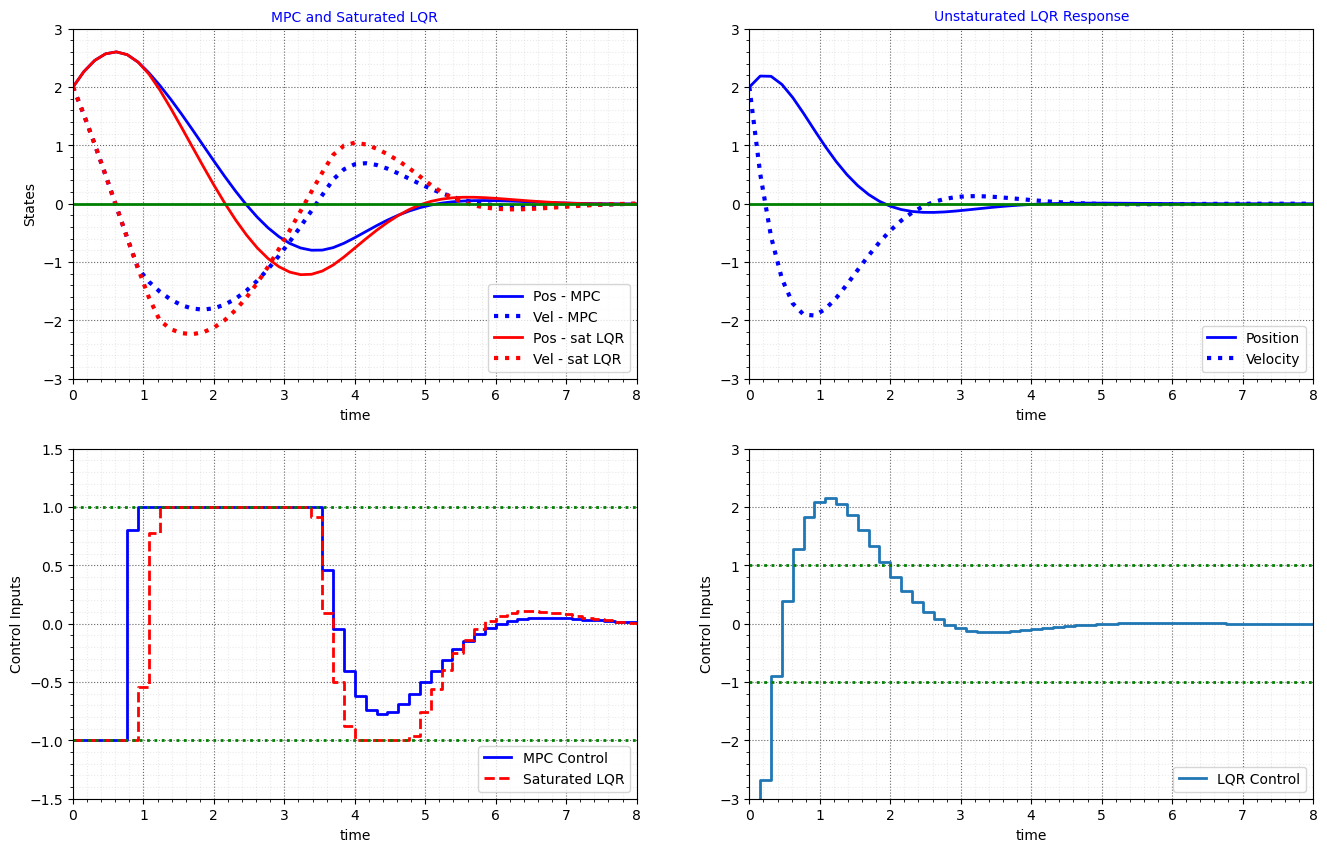

In [7]:
def plot_results(t,Xs,Xss_s,Xss_sat,title='MPC and Saturated LQR',save=False,filename='figs/def.png',Ref=np.hstack([0*t,0*t])):
    fig = plt.figure(2,figsize=(16,10))
    plt.subplot(221)
    plt.plot(t,Xs[0,:],'b-')
    plt.plot(t,Xs[1,:],'b:',lw=3)
    plt.plot(t,Xss_sat[0,:],'r-')
    plt.plot(t,Xss_sat[1,:],'r:',lw=3)
    plt.plot(t,Ref[0:2*Npts:2],'g')
    plt.xlabel('time')
    plt.ylabel('States')
    plt.legend(['Pos - MPC', 'Vel - MPC', 'Pos - sat LQR', 'Vel - sat LQR'],loc='lower right')
    plt.xlim([0,tf])
    val = np.round(np.max(Xs[0,:])+0.75,0)
    plt.ylim([-val,val])
    plt.title(title)
    nicegrid()
    
    plt.subplot(222)
    plt.plot(t,Xss_s[0,:],'b-')
    plt.plot(t,Xss_s[1,:],'b:',lw=3)
    plt.plot(t,Ref[0:2*Npts:2],'g')
    plt.xlabel('time')
    plt.legend(['Position', 'Velocity'],loc='lower right')
    plt.title('Unstaturated LQR Response')
    plt.xlim([0,tf])
    plt.ylim([-val,val])
    nicegrid()

    plt.subplot(223)
    plt.step(t,Xs[2,:],'b-')
    plt.step(t,Xss_sat[2,:],'r--')
    plt.plot(t,umax*np.ones_like(t),'g:')
    plt.plot(t,-umax*np.ones_like(t),'g:')
    plt.xlabel('time')
    plt.ylabel('Control Inputs')
    plt.legend(['MPC Control','Saturated LQR'],loc='lower right')
    plt.xlim([0,tf])
    nicegrid()
    plt.ylim([-umax*1.5, umax*1.5])

    plt.subplot(224)
    plt.step(t,Xss_s[2,:],'-')
    plt.plot(t,umax*np.ones_like(t),'g:')
    plt.plot(t,-umax*np.ones_like(t),'g:')
    plt.xlabel('time')
    plt.legend(['LQR Control'],loc='lower right')
    plt.ylim([-umax*3, umax*3])
    plt.xlim([0,tf])
    plt.ylabel('Control Inputs')
    nicegrid()
    if save:
        plt.savefig(filename)
    plt.show()

plot_results(t,Xs,Xss_s,Xss_sat,save=True,filename="figs/MPC1.png")

## Explicit MPC

* Use offline calculations to solve for MPC control inputs for wide range of states 
* Develop interplation of control inputs and store in lookup table
* Use look up table for online implementation

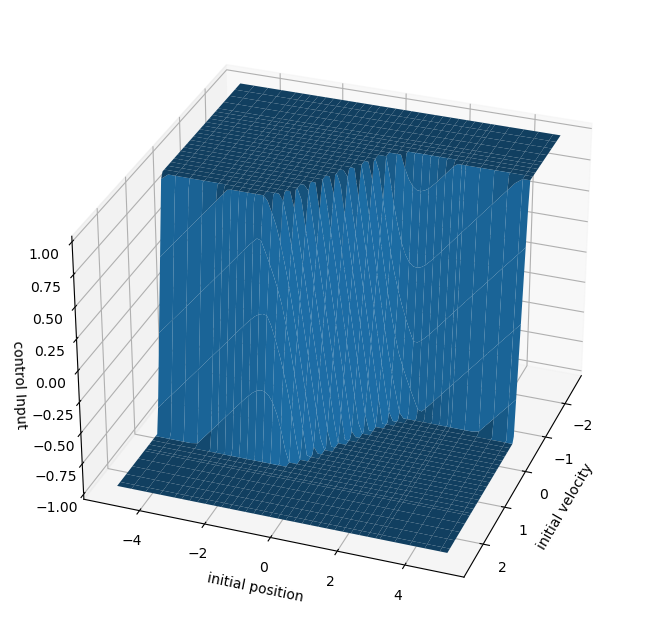

In [8]:
def fun(y, v):
    u = 0*y
    for i in range(0, len(y)):
        H2 = np.squeeze(np.asarray(2*np.array([[y[i]], [v[i]]]).T@G.T@W1@H))
        U = solve_qp(H3,H2,II,Ii)
        u[i] = U[0]
    return u

uboundary = 3 # search space
y = np.hstack((np.hstack((np.linspace(-5,-uboundary,10), np.linspace(-uboundary, uboundary, 50) )), np.linspace(uboundary, 5, 10) ))
v = y/2
Y, V = np.meshgrid(y, v)
u = np.array(fun(np.ravel(Y), np.ravel(V)))
U = u.reshape(V.shape)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(V, Y, U)
ax.set_xlabel('initial velocity')
ax.set_ylabel('initial position')
ax.set_zlabel('control Input')
ax.azim = 20
plt.savefig("figs/MPC2.png")
plt.show()

## Typical simulation result in state space
* Color shading shows control inputs at that state value
* State Tractory with MPC running shown in red 

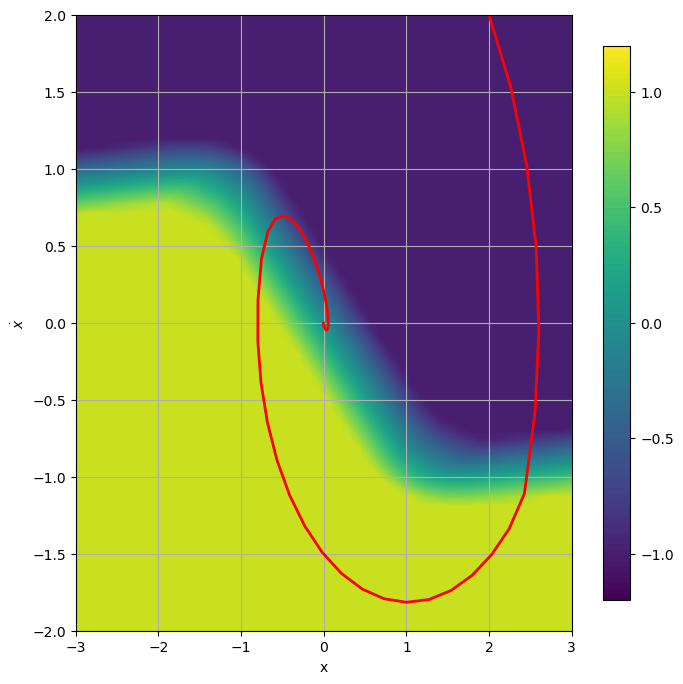

In [9]:
fig = plt.figure(8,figsize=(8,8))
cp = plt.contourf(Y, V, U,levels=np.linspace(-1.2,1.2,100))
fig.colorbar(cp,shrink=0.9,ticks=([-1,-0.5,0,0.5,1])) # Add a colorbar to a plot
plt.xlim(-3, 3)
plt.ylim(-2, 2)
plt.plot(Xs[0,:],Xs[1,:],'r')
plt.xlabel("x")
plt.ylabel(r"$\dot x$")
plt.savefig("figs/MPC3.png")
plt.show()

# Use the interplated control inputs in a cts simulation

/Users/jonathanhow/.local/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=78,67 m=4900 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


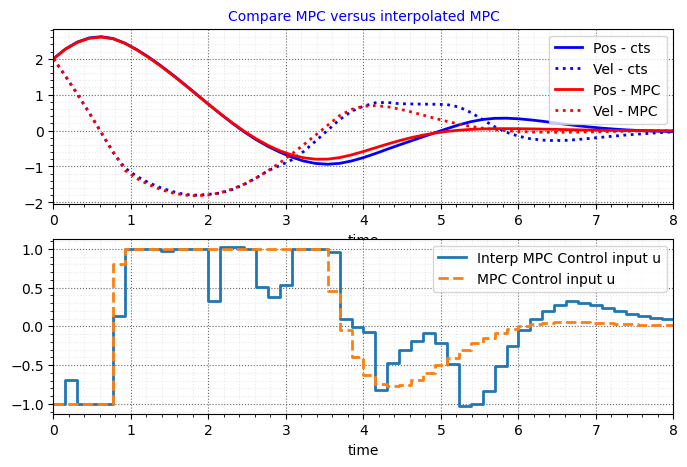

In [10]:
mpc = interp2d(Y, V, U)

def mpc_sim(x, t):
    y, v = x
    u = mpc(y,v)
    xdot = A@x + Bu@u # cts time
    return xdot

x = odeint(mpc_sim, (x0.item(0,0), x0.item(1,0)), t) # sim of cts 

fig = plt.figure(10,figsize=(8,5))
plt.subplot(211)
plt.plot(t,x[:,0],'b-')
plt.plot(t,x[:,1],'b:',lw=2)
plt.plot(t,Xs[0,:],'r-')
plt.plot(t,Xs[1,:],'r:',lw=2)
plt.xlabel('time')
plt.legend(['Pos - cts', 'Vel - cts', 'Pos - MPC', 'Vel - MPC'],loc='upper right')
plt.xlim(0, tf)
plt.title('Compare MPC versus interpolated MPC')
nicegrid()

plt.subplot(212)
plt.step(t, [mpc(x1, x2) for x1,x2 in x])
plt.step(t,Xs[2,:],'--',lw=2)
plt.xlabel('time')
plt.legend(['Interp MPC Control input u','MPC Control input u'],loc='upper right')
nicegrid()
plt.xlim(0, tf)
plt.savefig("figs/MPC4.png")
plt.show()

## Add Reference Tracking Capability

In [11]:
tf = 25 # sim end time
Npts = int(tf/Ts) # sim pts
t = np.linspace(0,tf,Npts) # sim time
ts1 = int(Npts/3)
ts2 = int(2*Npts/3)

x0 = np.array([[0], [0]])

def MPC_func(N = 20):     # N is MPC horizon
    T0 = time.time()

    G,H,W1,W2,Rxx,H3,II,Ii = MPC_matrices(N)
    # simple ref command input
    Ref = np.zeros(Npts*nz+2*N).reshape(Npts*nz+2*N,1) # pad end
    Ref[0:2*ts1:2] = 1
    Ref[2*ts1:2*ts2:2] = -1
    Ref[2*ts2:-1:2] = 0.5
    scale = 1.5 # scale up LQR to get ~zero tracking error
    x = x0
    xss = x0
    xsat = x0

    H2 = np.squeeze(np.asarray(2*(G@x-Ref[0:2*(N+1):1]).T@W1@H))
    U = solve_qp(H3,H2,II,Ii)
    Uss = -Kss@(xss - Ref[0:2])
    Usat = np.clip(Uss,-umax,umax)

    Xmpc = np.vstack((x,U[0]))
    Xss = np.vstack((xss,Uss))
    Xss_sat = np.vstack((xss,Usat))

    for k in np.arange(1,Npts):
        x = Ad@x + Bd*U[0]# MPC
        xss = Ad@xss + Bd*Uss # SS LQR 
        xsat = Ad@xsat + Bd*Usat # saturated LQR

        H2 = np.squeeze(np.asarray(2*(G@x-Ref[2*k:2*k+2*(N+1):1]).T@W1@H))
        U = solve_qp(H3,H2,II,Ii)
        Uss = -Kss@(xss - scale*Ref[2*k:2*k+2])
        Usat = np.clip(-Kss@(xsat - scale*Ref[2*k:2*k+2]),-umax,umax)
        
        Xmpc = np.concatenate((Xmpc,np.vstack((x,U[0]))),axis=1) # only going to use the first part of the MPC control
        Xss = np.concatenate((Xss,np.vstack((xss,Uss))),axis=1)
        Xss_sat = np.concatenate((Xss_sat,np.vstack((xsat,Usat))),axis=1)

    Title= str(r'$N\times T_s=$ '+str(round(N*Ts,3))+'sec, MPC CPU time: '+str(round((time.time()-T0)*1000,0))+' (msec)')
    plot_results(t,Xmpc,Xss,Xss_sat,title=Title,Ref=Ref)

interactive_plot = interactive(MPC_func, {'manual': False}, N=(2, 50, 1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=20, description='N', max=50, min=2), Output()), _dom_classes=('widget-in…

Code enables analysis of the MPC response compared to LQR/saturated LQR when we vary $N$ - the length of the planning window

* Longer $N$ should approach saturated LQR (adhoc - have little understanding of how that will work in general), with higher computation (normally)
* $N$ too small might lead to very myopic planning
* Note large control constraint violations in LQR result